# ModernBert Baseline

The purpose of this notebook is to train the ModernBert model on the original Bias in Bios dataset. The resulting accuracy and subclass accuracies on the test set for this model can then be compared to the CDA model, which will be trained and tested in a subsequent notebook.

*Table of Contents*

>[Setup](#scrollTo=zRBFU-Bx9TWO)

>[Tokenize inputs](#scrollTo=jeJH1UH7_doy)

> [Functions](#scrollTo=yvN2UE_2G40k)

>[ModernBert Baseline](#scrollTo=W-h3baOWmQbR)

>[Save baseline model to drive](#scrollTo=eEQ8LbfxjGRM)

> [Evaluate Baseline Metrics](#scrollTo=lgTfmmt2Cl0J)



---

**Baseline evaluation findings**

The ModernBert 'out of the box' model trained and evaluated on the Bias in Bios dataset exhibits bias in its ability to classify professions based on a professional bio. The model produces large gaps in true positive rates for predictions made on female and male bios, particularly for professions that are stereotypical of one gender, such as model, dietition, dj, pastor and surgeon.

The largest gap is for the model profession, with the true positive rate for females at 91% and males at 53%, resulting in a gap of about	38%. Other professions, such as dj and surgeon, show 19% and 17% gaps, respectively, favoring males with a higher true positive rate.

## Setup

In [1]:
# Install dependencies
!pip install -q transformers
!pip install -q datasets

In [33]:
# Install libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

from datasets import load_from_disk

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from functools import partial

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab-Notebooks/jordan-cda'

Mounted at /content/drive


In [4]:
# Load datasets
train = load_from_disk(path + '/data_original/train')
test = load_from_disk(path + '/data_original/test')
dev = load_from_disk(path + '/data_original/dev')

In [5]:
# Confirm load
print(f'Train shape: {train.shape}') # should be (257478, 3)
print(f'Test shape: {test.shape}') # should be (99069, 3)
print(f'Dev shape: {dev.shape}') # should be (39642, 3)

Train shape: (257478, 3)
Test shape: (99069, 3)
Dev shape: (39642, 3)


In [4]:
# Set number of classes for classification
num_professions = 28

In [5]:
# Load ModernBert
mbert = "answerdotai/ModernBERT-base"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert)
mbert_model = AutoModelForSequenceClassification.from_pretrained(mbert, num_labels= num_professions)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Functions

In [6]:
BATCH_SIZE = 32

In [7]:
MAX_LENGTH = 512

In [8]:
# Map professions to their label for plotting
professions = ['accountant', 'architect','attorney','chiropractor','comedian',
               'composer','dentist','dietitian','dj','filmmaker',
               'interior_designer','journalist','model','nurse','painter',
               'paralegal','pastor','personal_trainer','photographer','physician',
               'poet','professor','psychologist','rapper','software_engineer',
               'surgeon','teacher','yoga_teacher']

profession_map = {num:prof for num, prof in enumerate(professions)}

profession_map

{0: 'accountant',
 1: 'architect',
 2: 'attorney',
 3: 'chiropractor',
 4: 'comedian',
 5: 'composer',
 6: 'dentist',
 7: 'dietitian',
 8: 'dj',
 9: 'filmmaker',
 10: 'interior_designer',
 11: 'journalist',
 12: 'model',
 13: 'nurse',
 14: 'painter',
 15: 'paralegal',
 16: 'pastor',
 17: 'personal_trainer',
 18: 'photographer',
 19: 'physician',
 20: 'poet',
 21: 'professor',
 22: 'psychologist',
 23: 'rapper',
 24: 'software_engineer',
 25: 'surgeon',
 26: 'teacher',
 27: 'yoga_teacher'}

In [9]:
def compute_metrics(eval_pred, genders= None):
  """
  Computes evaluation metrics, including overall and gender-specific metrics.
  """
  preds, labels = eval_pred
  preds = np.argmax(preds, axis= 1)

  metrics = {
      'f1_macro': f1_score(labels, preds, average= 'macro'),
      'accuracy': accuracy_score(labels, preds),
      'conf_matrix_overall': confusion_matrix(labels, preds).tolist()
  }

  if genders is not None:
    for gender in np.unique(genders):
      mask = (genders == gender)
      cm = confusion_matrix(labels[mask], preds[mask])
      f1 = f1_score(labels[mask], preds[mask], average= 'macro')
      acc = accuracy_score(labels[mask], preds[mask])

      metrics[f'conf_matrix_{gender}'] = cm.tolist()
      metrics[f'f1_{gender}'] = f1
      metrics[f'accuracy_{gender}'] = acc

  return metrics

## Tokenize inputs

In [ ]:
print(train)

Dataset({
    features: ['hard_text', 'profession', 'gender'],
    num_rows: 257478
})


In [ ]:
def tokenize_inputs(batch):
  return mbert_tokenizer(batch['hard_text'],
                         padding= True,
                         truncation= True,
                         max_length= MAX_LENGTH,
                         return_tensors='pt')

In [ ]:
mbert_train_inputs = train.map(tokenize_inputs, batched=True, batch_size=BATCH_SIZE)
mbert_test_inputs = test.map(tokenize_inputs, batched=True, batch_size=BATCH_SIZE)
mbert_dev_inputs = dev.map(tokenize_inputs, batched=True, batch_size=BATCH_SIZE)

Map:   0%|          | 0/257478 [00:00<?, ? examples/s]

Map:   0%|          | 0/99069 [00:00<?, ? examples/s]

Map:   0%|          | 0/39642 [00:00<?, ? examples/s]

In [ ]:
# Check shapes- should have 5 columns now (original + input_ids + attention_mask)
print(mbert_train_inputs.shape)
print()
print(mbert_test_inputs.shape)
print()
print(mbert_dev_inputs.shape)

(257478, 5)

(99069, 5)

(39642, 5)


In [ ]:
# Identify label column
mbert_train_inputs = mbert_train_inputs.rename_column('profession', 'labels')
mbert_test_inputs = mbert_test_inputs.rename_column('profession', 'labels')
mbert_dev_inputs = mbert_dev_inputs.rename_column('profession', 'labels')

In [ ]:
# Save tokenized inputs to drive
mbert_train_inputs.save_to_disk(path + '/data_tokenized_inputs/mbert_train_inputs')
mbert_test_inputs.save_to_disk(path + '/data_tokenized_inputs/mbert_test_inputs')
mbert_dev_inputs.save_to_disk(path + '/data_tokenized_inputs/mbert_dev_inputs')

Saving the dataset (0/1 shards):   0%|          | 0/257478 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/99069 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/39642 [00:00<?, ? examples/s]

#### Reload tokenized inputs

In [10]:
# Run this cell to reload saved inputs
mbert_train_inputs = load_from_disk(path + '/data_tokenized_inputs/mbert_train_inputs')
mbert_dev_inputs = load_from_disk(path + '/data_tokenized_inputs/mbert_dev_inputs')

In [11]:
# Confirm load
print(f'Tokenized train inputs shape: {mbert_train_inputs.shape}')
print(f'Tokenized dev inputs shape: {mbert_dev_inputs.shape}')

Tokenized train inputs shape: (257478, 5)
Tokenized dev inputs shape: (39642, 5)


## ModernBert Baseline

In [12]:
training_args = TrainingArguments(
    output_dir= path + '/models_trained/mbert_baseline',
    save_strategy= 'epoch',
    eval_strategy= 'epoch',
    logging_strategy= 'epoch',
    per_device_train_batch_size= BATCH_SIZE,
    per_device_eval_batch_size= BATCH_SIZE,
    num_train_epochs= 3,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_macro',
    report_to= 'none'
)

In [13]:
trainer = Trainer(
    model= mbert_model,
    args= training_args,
    train_dataset= mbert_train_inputs,
    eval_dataset= mbert_dev_inputs,
    compute_metrics= partial(compute_metrics, genders= mbert_dev_inputs['gender']),
    data_collator= DataCollatorWithPadding(tokenizer=mbert_tokenizer)
)

In [14]:
results = trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy,Conf Matrix Overall,Conf Matrix 0,F1 0,Accuracy 0,Conf Matrix 1,F1 1,Accuracy 1
1,0.521200,0.444908,0.812774,0.862545,"[[449, 13, 34, 0, 0, 0, 0, 0, 0, 2, 0, 14, 6, 5, 0, 1, 2, 0, 4, 0, 4, 16, 1, 1, 3, 0, 9, 0], [2, 755, 11, 0, 1, 0, 0, 0, 1, 0, 2, 20, 3, 3, 6, 0, 3, 0, 18, 1, 3, 42, 2, 0, 124, 0, 15, 0], [16, 14, 3054, 0, 1, 0, 0, 0, 1, 2, 1, 48, 13, 15, 1, 1, 10, 1, 3, 6, 2, 43, 6, 0, 2, 0, 18, 0], [0, 1, 1, 167, 0, 0, 7, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 4, 0, 70, 0, 1, 0, 0, 0, 5, 4, 0], [0, 1, 5, 0, 237, 0, 0, 1, 1, 6, 0, 12, 9, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0], [0, 2, 0, 0, 2, 497, 0, 0, 6, 7, 0, 2, 1, 0, 3, 0, 1, 0, 1, 0, 9, 11, 0, 8, 3, 1, 7, 0], [0, 0, 7, 0, 1, 0, 1406, 0, 1, 0, 0, 2, 3, 2, 0, 0, 1, 1, 2, 8, 1, 6, 6, 0, 1, 8, 3, 0], [0, 0, 1, 1, 0, 0, 1, 342, 0, 0, 0, 4, 1, 15, 0, 0, 0, 9, 0, 7, 0, 9, 5, 0, 0, 0, 1, 0], [0, 1, 0, 0, 3, 1, 0, 0, 123, 0, 0, 4, 1, 1, 0, 0, 0, 0, 1, 0, 2, 2, 0, 8, 1, 0, 1, 1], [0, 1, 7, 0, 2, 2, 0, 0, 0, 606, 0, 21, 5, 1, 1, 0, 0, 0, 19, 1, 8, 17, 2, 3, 0, 0, 5, 0], [0, 42, 2, 0, 0, 0, 0, 0, 0, 0, 76, 7, 1, 2, 2, 0, 0, 0, 4, 0, 1, 4, 1, 0, 0, 0, 4, 0], [2, 12, 45, 0, 7, 2, 0, 1, 3, 21, 0, 1626, 16, 15, 3, 0, 10, 1, 38, 7, 33, 99, 13, 1, 6, 5, 28, 1], [1, 9, 18, 0, 5, 1, 0, 1, 2, 2, 0, 12, 622, 12, 1, 0, 4, 9, 18, 4, 6, 8, 2, 2, 1, 1, 9, 0], [3, 1, 15, 1, 1, 0, 0, 7, 0, 1, 0, 20, 6, 1623, 1, 0, 3, 2, 1, 114, 7, 33, 20, 0, 0, 10, 24, 3], [0, 8, 2, 0, 3, 2, 0, 0, 1, 8, 0, 8, 5, 1, 640, 0, 0, 0, 56, 0, 7, 26, 0, 1, 0, 1, 5, 0], [2, 0, 65, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 102, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0], [1, 2, 10, 0, 0, 0, 0, 0, 0, 1, 0, 10, 1, 3, 1, 0, 183, 0, 1, 1, 1, 16, 6, 0, 0, 0, 16, 0], [0, 0, 1, 2, 0, 0, 0, 4, 0, 0, 0, 4, 6, 0, 0, 0, 0, 120, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1], [2, 7, 14, 0, 7, 3, 0, 2, 3, 33, 0, 63, 15, 7, 38, 0, 1, 2, 2174, 0, 13, 26, 2, 2, 0, 1, 12, 1], [0, 2, 18, 30, 0, 1, 6, 7, 0, 2, 0, 12, 2, 47, 0, 0, 1, 0, 2, 3670, 5, 168, 25, 0, 1, 92, 9, 0], [0, 1, 6, 0, 4, 2, 0, 0, 1, 4, 0, 25, 0, 1, 2, 0, 6, 0, 5, 2, 600, 23, 0, 7, 0, 0, 13, 0], [14, 55, 89, 1, 2, 21, 8, 12, 0, 14, 1, 77, 1, 81, 15, 0, 17, 1, 20, 123, 55, 10861, 117, 0, 33, 97, 93, 0], [2, 3, 15, 1, 1, 1, 0, 3, 1, 0, 0, 37, 2, 27, 1, 0, 7, 2, 4, 20, 17, 208, 1443, 0, 1, 6, 35, 2], [0, 0, 2, 0, 3, 0, 0, 0, 4, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 123, 0, 0, 0, 0], [1, 37, 7, 0, 0, 1, 0, 1, 0, 1, 0, 19, 2, 1, 1, 0, 2, 1, 4, 1, 2, 48, 2, 1, 549, 0, 11, 0], [1, 1, 4, 3, 0, 1, 44, 0, 0, 0, 0, 3, 1, 7, 0, 0, 1, 0, 1, 261, 2, 41, 4, 0, 0, 980, 5, 0], [7, 12, 40, 4, 7, 13, 0, 3, 3, 5, 0, 106, 26, 27, 10, 1, 43, 9, 19, 3, 40, 153, 33, 3, 6, 2, 1030, 16], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 21, 135]]","[[285, 9, 25, 0, 0, 0, 0, 0, 0, 0, 0, 10, 3, 2, 0, 0, 2, 0, 3, 0, 4, 8, 0, 1, 1, 0, 4, 0], [1, 570, 9, 0, 0, 0, 0, 0, 1, 0, 0, 15, 1, 2, 6, 0, 3, 0, 11, 1, 3, 28, 1, 0, 111, 0, 9, 0], [12, 12, 1889, 0, 1, 0, 0, 0, 1, 1, 0, 28, 7, 1, 0, 0, 7, 1, 2, 6, 1, 30, 1, 0, 1, 0, 9, 0], [0, 0, 1, 126, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 50, 0, 1, 0, 0, 0, 5, 3, 0], [0, 1, 5, 0, 186, 0, 0, 1, 1, 4, 0, 9, 5, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0], [0, 2, 0, 0, 2, 413, 0, 0, 6, 7, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 6, 11, 0, 6, 3, 1, 6, 0], [0, 0, 7, 0, 1, 0, 906, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 2, 6, 0, 5, 2, 0, 1, 6, 2, 0], [0, 0, 1, 1, 0, 0, 0, 20, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 3, 1, 0, 0, 108, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 8, 1, 0, 1, 0], [0, 1, 5, 0, 2, 1, 0, 0, 0, 414, 0, 9, 1, 0, 1, 0, 0, 0, 12, 1, 6, 9, 1, 3, 0, 0, 4, 0], [0, 14, 1, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0], [2, 7, 30, 0, 6, 2, 0, 0, 2, 10, 0, 819, 4, 0, 1, 0, 8, 0, 17, 1, 14, 56, 4, 0, 6, 4, 14, 0], [1, 8, 11, 0, 5, 1, 0, 0, 1, 1, 0, 5, 67, 1, 1, 0, 3, 1, 2, 3, 5, 6, 1, 0, 1, 1, 5, 0], [0, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 136, 0, 0, 0, 0, 0,

## Save baseline to drive

In [35]:
# Run this to set the file path
mbert_baseline_checkpoint_filepath = path + '/models_trained/mbert_baseline'

In [16]:
# Run this to save the baseline model
mbert_model.save_pretrained(mbert_baseline_checkpoint_filepath)

In [36]:
# Run this code to reload the baseline model
mbert_model = AutoModelForSequenceClassification.from_pretrained(mbert_baseline_checkpoint_filepath)

## Evaluate Baseline Metrics

In [18]:
# Save metrics from epochs
eval_metrics = trainer.evaluate(mbert_dev_inputs)

In [34]:
# Save metrics to drive
metrics_filepath = path + '/models_trained/mbert_baseline/eval_metrics.json'

with open(metrics_filepath, 'w') as f:
  json.dump(eval_metrics, f)

print(f'Evaluation metrics saved to: {metrics_filepath}')

Evaluation metrics saved to: /content/drive/MyDrive/Colab-Notebooks/jordan-cda/models_trained/mbert_baseline/eval_metrics.json


In [ ]:
# Reload metrics if needed
with open(metrics_filepath, 'r') as f:
  eval_metrics = json.load(f)



---



In [20]:
# Print metrics for best model
print(f'Overall Accuracy: {round(eval_metrics["eval_accuracy"]*100,2)}%\n',
      f'Accuracy- Males: {round(eval_metrics['eval_accuracy_0']*100,2)}%\n',
      f'Accuracy-Females: {round(eval_metrics['eval_accuracy_1']*100,2)}%\n',
      f'\n',
      f'Overall F1-Macro: {round(eval_metrics['eval_f1_macro'],4)}\n',
      f'F1-Macro- Males: {round(eval_metrics['eval_f1_0'],4)}\n',
      f'F1-Macro- Females: {round(eval_metrics['eval_f1_1'],4)}')

Overall Accuracy: 86.47%
 Accuracy- Males: 85.93%
 Accuracy-Females: 87.11%
 
 Overall F1-Macro: 0.8194
 F1-Macro- Males: 0.7904
 F1-Macro- Females: 0.8144


In [22]:
# Normalize gendered confusion matrices
cmnorm_females = np.array(eval_metrics['eval_conf_matrix_1']) / np.array(eval_metrics['eval_conf_matrix_1']).sum(axis=1)
cmnorm_males = np.array(eval_metrics['eval_conf_matrix_0']) / np.array(eval_metrics['eval_conf_matrix_0']).sum(axis=1)

In [ ]:
# Compute the true positive rates
tp_females = np.diag(cmnorm_females)
tp_males = np.diag(cmnorm_males)


In [28]:
# Create a dataframe to show difference between true positive rates
tp_data = {
    'Females': tp_females,
    'Males': tp_males
}

tp_df = pd.DataFrame(tp_data, index = professions)
tp_df['True Positive Difference'] = tp_df['Females'] - tp_df['Males']

In [31]:
tp_df.sort_values(by= 'True Positive Difference')

,Females,Males,True Positive Difference
dj,0.636364,0.828125,-0.191761
surgeon,0.643564,0.812608,-0.169044
pastor,0.590164,0.671875,-0.081711
filmmaker,0.826840,0.863830,-0.036990
architect,0.733333,0.766839,-0.033506
photographer,0.858131,0.889174,-0.031042
personal_trainer,0.757576,0.782051,-0.024476
professor,0.923395,0.933817,-0.010422
journalist,0.820850,0.828203,-0.007352
dentist,0.957282,0.960805,-0.003524


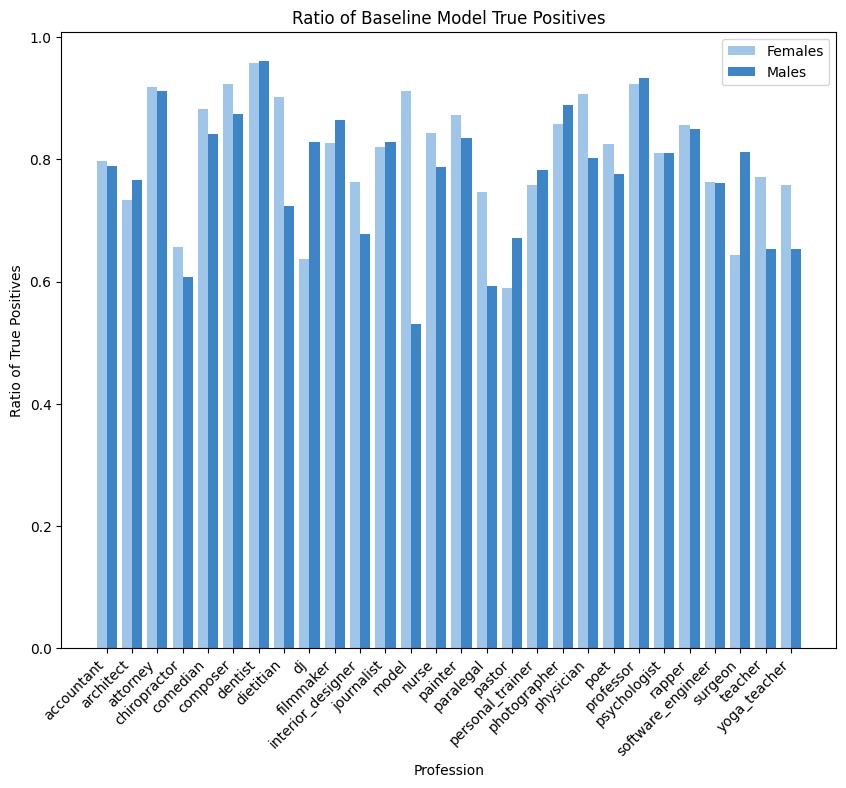

In [32]:
# Plot bar charts for true positives rates by gender and profession
w, x = 0.4, np.arange(len(professions))

fig, ax = plt.subplots(figsize= (10,8))
ax.bar(x - w/2, tp_females, width=w, label='Females', color = '#9fc5e8')
ax.bar(x + w/2, tp_males, width=w, label='Males', color = '#3d85c6')

ax.set_xticks(x) # Use set_xticks
ax.set_xticklabels(professions, rotation= 45, ha= 'right')
ax.set_xlabel('Profession')
ax.set_ylabel('Ratio of True Positives')
ax.set_title('Ratio of Baseline Model True Positives')
ax.legend()

plt.show()